# NYC 311 Complaints vs Storm Water Flooding by Neighborhood Tabulation Areas (NTAs)
Author: Ho Hsieh 
[LinkedIn](https://www.linkedin.com/in/hohsieh/)
[GitHub](https://github.com/hohsieh)


In this study, we want to examine if the counts of NYC 311 street flood complaints can be explained by flood area within the Neighborhood Tabulation Areas (NTAs).

The 311 flood complaints data are prepared from a previous project and can be accessed at [here](https://raw.githubusercontent.com/mebauer/nyc-311-street-flooding/main/data/street-flooding-complaints.csv)

The flood data used here are the modeled New York City Stormwater Flood Maps (Moderate Stormwater Flood with Current Sea Level Rise) [here](https://experience.arcgis.com/experience/6f4cc60710dc433585790cd2b4b5dd0e)

The notebook contains 3 main steps
1. Get data
2. Spatial Aggregation: get zonal statistics of complaint count by NTA, flood area by NTA
4. Statistical Analysis: correlation, regression between complaint counts and stormwater flood


In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [2]:
!pwd
%cd /Users/ho/Documents/GitHub/nyc-flood
!pwd

/Users/ho/Documents/GitHub/nyc-flood/src
/Users/ho/Documents/GitHub/nyc-flood
/Users/ho/Documents/GitHub/nyc-flood


## Get Data

### Get Data -- NYC 311 Complaints

In [3]:
path = 'https://raw.githubusercontent.com/mebauer/nyc-311-street-flooding/main/data/street-flooding-complaints.csv'

df_311 = pd.read_csv(path, low_memory=False)

print(df_311.shape)
df_311.head()

(27902, 34)


unique_key             created_date agency  \
0    48542220  2020-12-31T15:41:00.000    DEP   
1    48536430  2020-12-31T14:49:00.000    DEP   
2    48539361  2020-12-31T14:03:00.000    DEP   
3    48543132  2020-12-31T13:48:00.000    DEP   
4    48536441  2020-12-31T13:10:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip      incident_address      street_name  \
0  Street Flooding (SJ)       11420.0     117-17 135 STREET       135 STREET   
1  Street Flooding (SJ)       11357.0      20-24 150 STREET       150 STREET   
2  Street Flooding (SJ)       11228.0         7223 8 AVENUE         8 AVENUE   
3  Street Flooding (SJ)       10032.0                   NaN              NaN   
4  Street Flooding (SJ)       11234.0  3123 FILLMORE AVENUE  FILLMORE AVENUE   

  cross_street_1  ...                                           location  \
0      FOCH BLVD  ...  {'latitude': '40.67703755925495', 'longitude':...   
1         20 AVE  ...  {'latitude': '40.78072630540092', 'longitude':...   
2          72 ST  ...  {'latitude': '40.62849640806448', 'longitude':...   
3            NaN  ...  {'latitude': '40.841051689545516', 'longitude'...   
4        E 31 ST  ...  {'latitude': '40.609203447399906', 'longitude'...   

  intersection_street_1 intersection_street_2              closed_date  \
0                   NaN                   NaN  2021-01-01T00:20:00.000   
1                   NaN                   NaN  2021-01-04T10:15:00.000   
2                   NaN                   NaN  2021-01-02T11:25:00.000   
3       RIVERSIDE DRIVE      WEST  165 STREET  2020-12-31T14:50:00.000   
4                   NaN                   NaN  2021-01-03T10:45:00.000   

                              resolution_description  \
0  Please call 311 for further information. If yo...   
1  The Department of Environment Protection inspe...   
2  The Department of Environmental Protection has...   
3  Please call 311 for further information. If yo...   
4  The Department of Environmental Protection ins...   

   resolution_action_updated_date location_type  landmark  facility_type  \
0         2021-01-01T00:20:00.000           NaN       NaN            NaN   
1         2021-01-04T10:15:00.000           NaN       NaN            NaN   
2         2021-01-02T11:25:00.000           NaN       NaN            NaN   
3         2020-12-31T14:50:00.000           NaN       NaN            NaN   
4         2021-01-03T10:45:00.000           NaN       NaN            NaN   

  due_date  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  

[5 rows x 34 columns]

In [4]:
df_311[["latitude", "longitude"]].head()

latitude  longitude
0  40.677038 -73.804417
1  40.780726 -73.814288
2  40.628496 -74.016810
3  40.841052 -73.944679
4  40.609203 -73.936548

In [5]:
print(df_311.columns)
print(df_311.info())


Index(['unique_key', 'created_date', 'agency', 'agency_name', 'complaint_type',
       'descriptor', 'incident_zip', 'incident_address', 'street_name',
       'cross_street_1', 'cross_street_2', 'address_type', 'city', 'status',
       'community_board', 'bbl', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'intersection_street_1', 'intersection_street_2',
       'closed_date', 'resolution_description',
       'resolution_action_updated_date', 'location_type', 'landmark',
       'facility_type', 'due_date'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27902 entries, 0 to 27901
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27902 non-null  int64  
 1   created_date             

In [6]:
# to date_time
df_311['date_time'] = pd.to_datetime(df_311['created_date'], infer_datetime_format=True)
df_311 = df_311.sort_values(by='date_time').reset_index(drop=True)

df_311.date_time.head()

0   2010-01-02 08:26:00
1   2010-01-02 12:00:00
2   2010-01-02 17:45:00
3   2010-01-04 16:47:00
4   2010-01-05 10:37:00
Name: date_time, dtype: datetime64[ns]

In [7]:
# make spatial info

gdf_311 = gpd.GeoDataFrame(
    df_311,
    geometry=gpd.points_from_xy(
        df_311['x_coordinate_state_plane'],
        df_311['y_coordinate_state_plane']
    )
)

gdf_311 = gdf_311.set_crs(epsg=2263)
gdf_311.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Get Data -- NYC Stormwater Flood Map

Quote from the Data's Data Dictionary

> The geodatabase contains a single feature class that shows two (2) flooding categories.
>
> * The "Nuisance Flooding (ponding depths greater or equal to 4 in. and less than 1 ft.)" and
> 
> * "Deep and Contiguous Flooding (ponding depths 1 ft. and greater)"
>
> categories were created using hydrologic and hydraulic computer models and represent flood risk due to extreme rainfall.  Please refer to the New York City Stormwater Resiliency Plan for more information on the purpose of the study, how datasets were developed, applications for this data, and other details.
>
>
> A coded value domain is used for the "Flooding_Category" field. See Column Info tab of the Data Dictionary for definition of each code.
>
> The New York City Stormwater Flood Maps show areas of potential flooding of at least 0.25 contiguous acres with flood depths of 4 inches or more.  This dataset contains some potential flooding areas less than 0.25 acres due to proximity and overlap with masking layers.


In [15]:
fn_sw = "/Users/ho/Documents/GitHub/nyc-flood/data/raw/NYC_Stormwater_Flood_Map_-_Moderate_Flood_with_Current_Sea_Levels/NYC Stormwater Flood Map - Moderate Flood with Current Sea Levels.gdb"
# fn_sw = "/Users/mac/Downloads/nyc-flood/data/raw/NYC_Stormwater_Flood_Map_-_Moderate_Flood_with_Current_Sea_Levels/NYC Stormwater Flood Map - Moderate Flood with Current Sea Levels.gdb"

gdf_sw = gpd.read_file(fn_sw)
print(gdf_sw.shape)
print(gdf_sw.head)


(2, 4)
<bound method NDFrame.head of    Flooding_Category  Shape_Length    Shape_Area  \
0                  1  6.456233e+06  7.937311e+07   
1                  2  2.601608e+06  4.119771e+07   

                                            geometry  
0  MULTIPOLYGON Z (((917257.748 120888.120 0.000,...  
1  MULTIPOLYGON Z (((917182.612 120877.544 0.000,...  >


In [16]:
print(gdf_sw.columns)
print(gdf_sw.info())

Index(['Flooding_Category', 'Shape_Length', 'Shape_Area', 'geometry'], dtype='object')
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Flooding_Category  2 non-null      int64   
 1   Shape_Length       2 non-null      float64 
 2   Shape_Area         2 non-null      float64 
 3   geometry           2 non-null      geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 192.0 bytes
None


### Get Data -- NYC NTAs

In [11]:
fn_nta = glob.glob("/Users/ho/Documents/GitHub/nyc-flood/data/raw/nynta2020_23a/*.shp")[0]
# fn_nta = glob.glob("/Users/mac/Downloads/nyc-flood/data/raw/nynta2020_23a/*.shp")[0]

gdf_nta = gpd.read_file(fn_nta)

print(gdf_nta.shape)
print(gdf_nta.head)

(262, 12)
<bound method NDFrame.head of      BoroCode       BoroName CountyFIPS NTA2020                      NTAName  \
0           3       Brooklyn        047  BK0101                   Greenpoint   
1           3       Brooklyn        047  BK0102                 Williamsburg   
2           3       Brooklyn        047  BK0103           South Williamsburg   
3           3       Brooklyn        047  BK0104            East Williamsburg   
4           3       Brooklyn        047  BK0201             Brooklyn Heights   
..        ...            ...        ...     ...                          ...   
257         5  Staten Island        085  SI0391      Freshkills Park (South)   
258         5  Staten Island        085  SI9561               Fort Wadsworth   
259         5  Staten Island        085  SI9591  Hoffman & Swinburne Islands   
260         5  Staten Island        085  SI9592                 Miller Field   
261         5  Staten Island        085  SI9593             Great Kills Park   


In [12]:
def get_name(x):
    return " ".join(x.split("(")[0].split(" ")[1:]).strip()

gdf_nta["CDTAName_2"] = gdf_nta["CDTAName"].apply(get_name)

gdf_nta["CDTAName_2"].head(10)

0          Williamsburg-Greenpoint
1          Williamsburg-Greenpoint
2          Williamsburg-Greenpoint
3          Williamsburg-Greenpoint
4    Downtown Brooklyn-Fort Greene
5    Downtown Brooklyn-Fort Greene
6    Downtown Brooklyn-Fort Greene
7    Downtown Brooklyn-Fort Greene
8    Downtown Brooklyn-Fort Greene
9               Bedford-Stuyvesant
Name: CDTAName_2, dtype: object

### Visualize

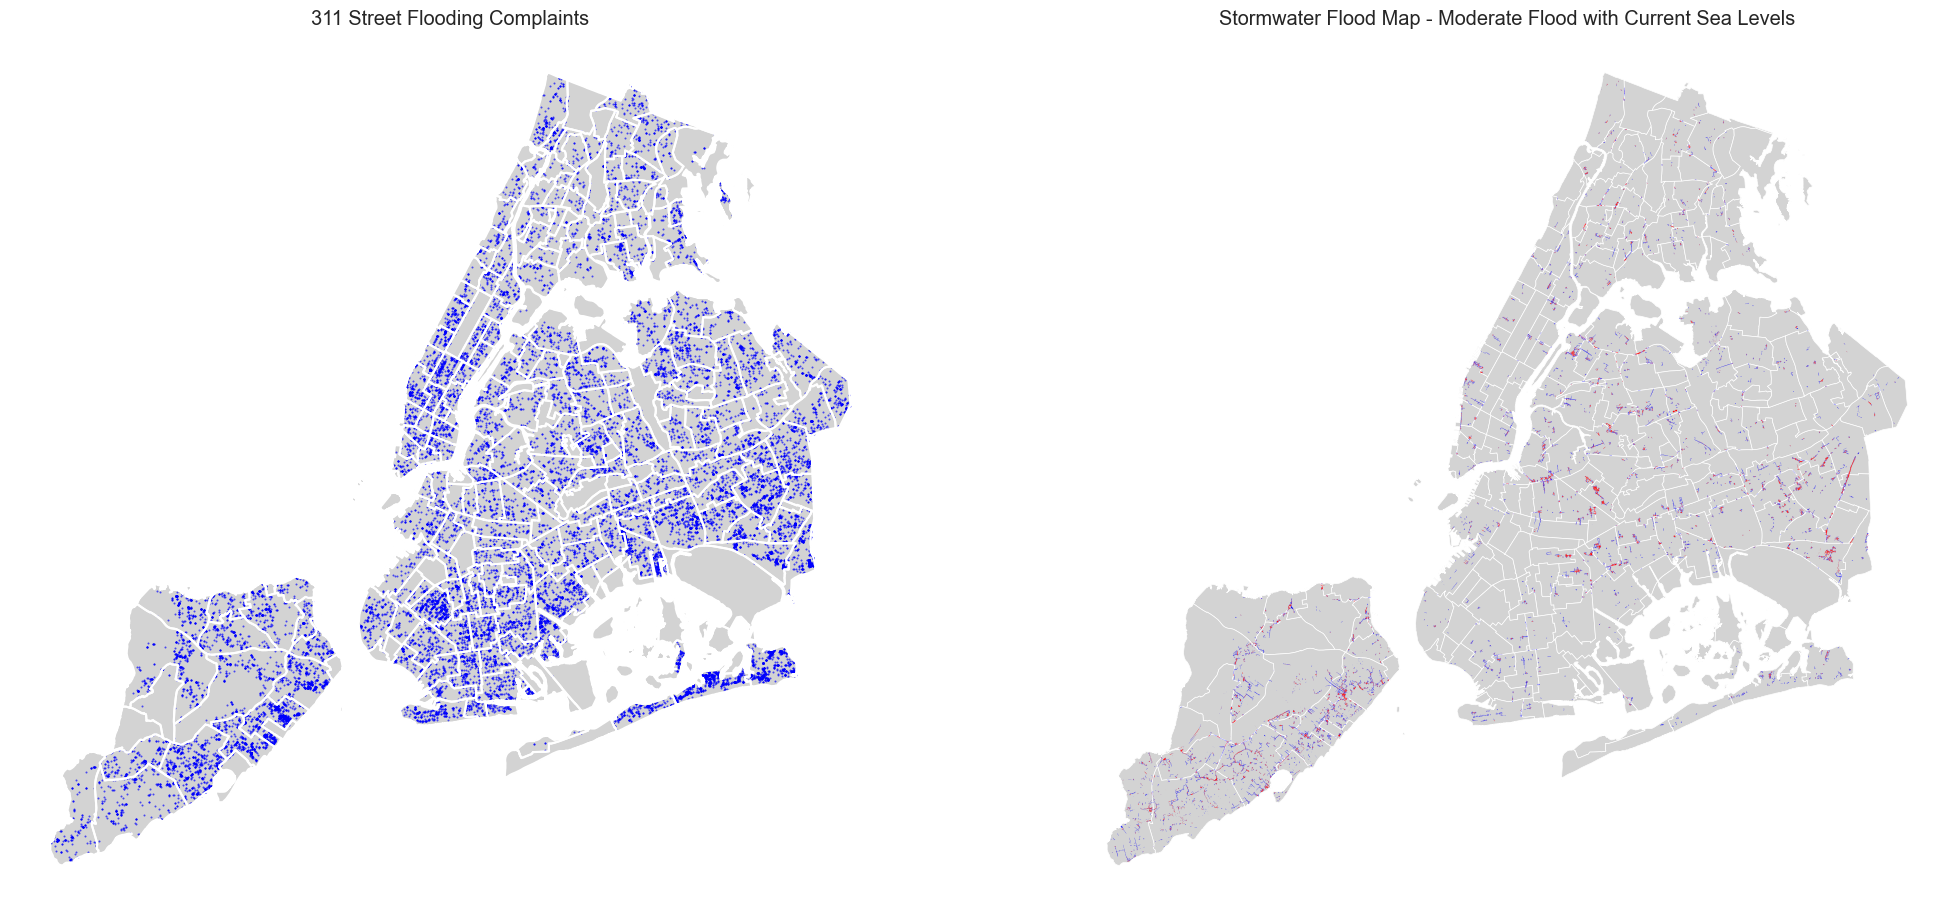

In [148]:
plt.style.use('ggplot')

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(25, 25))

gdf_nta.plot(ax=axs[0], color="lightgrey", edgecolor='white', markersize=1)
gdf_311.plot(ax=axs[0], markersize=1, color="blue", alpha=0.5)
gdf_nta.boundary.plot(ax=axs[0], color="white", markersize=0.01)

gdf_nta.plot(ax=axs[1], color="lightgrey", edgecolor='white', markersize=1)
gdf_sw[gdf_sw['Flooding_Category']==1].plot(color="blue", ax=axs[1], legend=True, edgecolor='None')
gdf_sw[gdf_sw['Flooding_Category']==2].plot(color="red", ax=axs[1], legend=True, edgecolor='None')


axs[0].set_title("311 Street Flooding Complaints")
axs[1].set_title("Stormwater Flood Map - Moderate Flood with Current Sea Levels")
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.show()

## Spatial Aggregation

In [18]:
# same coordinate system
print(gdf_311.crs)
print(gdf_sw.crs)
print(gdf_nta.crs)

# unit for epsg 2263 is ft

EPSG:2263
EPSG:2263
EPSG:2263


In [19]:
# gdf_sw['Flooding_Category'].head()
# gdf_sw.info()
gdf_nta.info()
gdf_nta.head()
gdf_nta[["NTA2020", "NTAName", "NTAAbbrev", "NTAType"]].head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BoroCode    262 non-null    int64   
 1   BoroName    262 non-null    object  
 2   CountyFIPS  262 non-null    object  
 3   NTA2020     262 non-null    object  
 4   NTAName     262 non-null    object  
 5   NTAAbbrev   262 non-null    object  
 6   NTAType     262 non-null    object  
 7   CDTA2020    262 non-null    object  
 8   CDTAName    262 non-null    object  
 9   Shape_Leng  262 non-null    float64 
 10  Shape_Area  262 non-null    float64 
 11  geometry    262 non-null    geometry
 12  CDTAName_2  262 non-null    object  
dtypes: float64(2), geometry(1), int64(1), object(9)
memory usage: 26.7+ KB


NTA2020             NTAName  NTAAbbrev NTAType
0  BK0101          Greenpoint      Grnpt       0
1  BK0102        Williamsburg   Wllmsbrg       0
2  BK0103  South Williamsburg  SWllmsbrg       0
3  BK0104   East Williamsburg  EWllmsbrg       0
4  BK0201    Brooklyn Heights      BkHts       0

### 1. Zonal Statistics - get area of storm water floods by nta

In [20]:
# flood cat 1

gdf_sw1 = gdf_sw[gdf_sw['Flooding_Category']==1].copy()

# Perform a spatial overlay between the two datasets
col_area = "area_1"
intersect = gpd.overlay(gdf_nta, gdf_sw1, how='intersection') #Intersect
intersect[col_area] = intersect.geometry.area #Calculate area column
interarea = intersect.groupby('NTA2020')[col_area].sum() #Sum per id_col

interarea_sw1 = interarea.copy()
interarea_sw1.head()

NTA2020
BK0101    467067.461780
BK0102    530276.021515
BK0103    640600.725771
BK0104    537490.748283
BK0202     39532.737758
Name: area_1, dtype: float64

In [21]:
# flood cat 2

gdf_sw2 = gdf_sw[gdf_sw['Flooding_Category']==2].copy()

# Perform a spatial overlay between the two datasets
col_area = "area_2"
intersect = gpd.overlay(gdf_nta, gdf_sw2, how='intersection') #Intersect
intersect[col_area] = intersect.geometry.area #Calculate area column
interarea = intersect.groupby('NTA2020')[col_area].sum() #Sum per id_col

interarea_sw2 = interarea.copy()
interarea_sw2.head()

NTA2020
BK0101    205400.901252
BK0102    317958.625597
BK0103    656351.894516
BK0104     92390.450821
BK0202      9288.103214
Name: area_2, dtype: float64

In [22]:
# Merge the 2 type of floods to NTA and calculate sum (area_all)

gdf_sw_nta = gdf_nta.merge(right=interarea_sw1, how='left', left_on='NTA2020', right_index=True)
gdf_sw_nta = gdf_sw_nta.merge(right=interarea_sw2, how='left', left_on='NTA2020', right_index=True)
gdf_sw_nta["area_1"] = gdf_sw_nta["area_1"].fillna(0)
gdf_sw_nta["area_2"] = gdf_sw_nta["area_2"].fillna(0)

gdf_sw_nta["area_all"] = gdf_sw_nta["area_1"] + gdf_sw_nta["area_2"]
gdf_sw_nta["area_all"] = gdf_sw_nta["area_all"].fillna(0)

gdf_sw_nta.head()

BoroCode  BoroName CountyFIPS NTA2020             NTAName  NTAAbbrev  \
0         3  Brooklyn        047  BK0101          Greenpoint      Grnpt   
1         3  Brooklyn        047  BK0102        Williamsburg   Wllmsbrg   
2         3  Brooklyn        047  BK0103  South Williamsburg  SWllmsbrg   
3         3  Brooklyn        047  BK0104   East Williamsburg  EWllmsbrg   
4         3  Brooklyn        047  BK0201    Brooklyn Heights      BkHts   

  NTAType CDTA2020                                           CDTAName  \
0       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
1       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
2       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
3       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
4       0     BK02  BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...   

     Shape_Leng    Shape_Area  \
0  28914.172236  3.532185e+07   
1  28158.316197  2.886214e+07   
2  18250.280262  1.520896e+07   
3  43184.772815  5.226621e+07   
4  14312.504911  9.982322e+06   

                                            geometry  \
0  POLYGON ((1003059.997 204572.025, 1002991.367 ...   
1  POLYGON ((994849.011 203499.267, 994911.093 20...   
2  POLYGON ((998047.210 196303.325, 998157.901 19...   
3  POLYGON ((1005302.497 199455.730, 1005307.792 ...   
4  POLYGON ((986367.735 190549.239, 985813.835 19...   

                      CDTAName_2         area_1         area_2      area_all  
0        Williamsburg-Greenpoint  467067.461780  205400.901252  6.724684e+05  
1        Williamsburg-Greenpoint  530276.021515  317958.625597  8.482346e+05  
2        Williamsburg-Greenpoint  640600.725771  656351.894516  1.296953e+06  
3        Williamsburg-Greenpoint  537490.748283   92390.450821  6.298812e+05  
4  Downtown Brooklyn-Fort Greene       0.000000       0.000000  0.000000e+00

### 2. Zonal Statistics - get counts of 311 flood complaints by nta

In [23]:
# gdf_311

joined_data = gpd.sjoin(gdf_311, gdf_nta, how='right', op='within')
count_pt = joined_data.groupby('NTA2020').size().reset_index(name='count_311')
count_pt.head()


/Users/ho/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NTA2020  count_311
0  BK0101        109
1  BK0102         79
2  BK0103        136
3  BK0104         82
4  BK0201         24

In [25]:

# gdf_sw_nta.drop(columns=["count_311_x", "count_311_y", "count_311"], inplace=True)
gdf_sw_nta.head()

BoroCode  BoroName CountyFIPS NTA2020             NTAName  NTAAbbrev  \
0         3  Brooklyn        047  BK0101          Greenpoint      Grnpt   
1         3  Brooklyn        047  BK0102        Williamsburg   Wllmsbrg   
2         3  Brooklyn        047  BK0103  South Williamsburg  SWllmsbrg   
3         3  Brooklyn        047  BK0104   East Williamsburg  EWllmsbrg   
4         3  Brooklyn        047  BK0201    Brooklyn Heights      BkHts   

  NTAType CDTA2020                                           CDTAName  \
0       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
1       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
2       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
3       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
4       0     BK02  BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...   

     Shape_Leng    Shape_Area  \
0  28914.172236  3.532185e+07   
1  28158.316197  2.886214e+07   
2  18250.280262  1.520896e+07   
3  43184.772815  5.226621e+07   
4  14312.504911  9.982322e+06   

                                            geometry  \
0  POLYGON ((1003059.997 204572.025, 1002991.367 ...   
1  POLYGON ((994849.011 203499.267, 994911.093 20...   
2  POLYGON ((998047.210 196303.325, 998157.901 19...   
3  POLYGON ((1005302.497 199455.730, 1005307.792 ...   
4  POLYGON ((986367.735 190549.239, 985813.835 19...   

                      CDTAName_2         area_1         area_2      area_all  
0        Williamsburg-Greenpoint  467067.461780  205400.901252  6.724684e+05  
1        Williamsburg-Greenpoint  530276.021515  317958.625597  8.482346e+05  
2        Williamsburg-Greenpoint  640600.725771  656351.894516  1.296953e+06  
3        Williamsburg-Greenpoint  537490.748283   92390.450821  6.298812e+05  
4  Downtown Brooklyn-Fort Greene       0.000000       0.000000  0.000000e+00

In [26]:
# join count_311 with NTA and zonal stats for stormwater

try:
    # drop column if already exist
    gdf_sw_nta.drop(columns=["count_311"], inplace=True)
except:
    pass

gdf_sw_nta = gdf_sw_nta.merge(right=count_pt, how='left', on='NTA2020')
gdf_sw_nta["count_311"] = gdf_sw_nta["count_311"].fillna(0)

gdf_sw_nta.head()

BoroCode  BoroName CountyFIPS NTA2020             NTAName  NTAAbbrev  \
0         3  Brooklyn        047  BK0101          Greenpoint      Grnpt   
1         3  Brooklyn        047  BK0102        Williamsburg   Wllmsbrg   
2         3  Brooklyn        047  BK0103  South Williamsburg  SWllmsbrg   
3         3  Brooklyn        047  BK0104   East Williamsburg  EWllmsbrg   
4         3  Brooklyn        047  BK0201    Brooklyn Heights      BkHts   

  NTAType CDTA2020                                           CDTAName  \
0       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
1       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
2       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
3       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
4       0     BK02  BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...   

     Shape_Leng    Shape_Area  \
0  28914.172236  3.532185e+07   
1  28158.316197  2.886214e+07   
2  18250.280262  1.520896e+07   
3  43184.772815  5.226621e+07   
4  14312.504911  9.982322e+06   

                                            geometry  \
0  POLYGON ((1003059.997 204572.025, 1002991.367 ...   
1  POLYGON ((994849.011 203499.267, 994911.093 20...   
2  POLYGON ((998047.210 196303.325, 998157.901 19...   
3  POLYGON ((1005302.497 199455.730, 1005307.792 ...   
4  POLYGON ((986367.735 190549.239, 985813.835 19...   

                      CDTAName_2         area_1         area_2      area_all  \
0        Williamsburg-Greenpoint  467067.461780  205400.901252  6.724684e+05   
1        Williamsburg-Greenpoint  530276.021515  317958.625597  8.482346e+05   
2        Williamsburg-Greenpoint  640600.725771  656351.894516  1.296953e+06   
3        Williamsburg-Greenpoint  537490.748283   92390.450821  6.298812e+05   
4  Downtown Brooklyn-Fort Greene       0.000000       0.000000  0.000000e+00   

   count_311  
0        109  
1         79  
2        136  
3         82  
4         24

In [27]:
gdf_sw_nta.to_file("/Users/ho/Documents/GitHub/nyc-flood/data/processed/nta_flood_vs_311.shp")

### 3. Visualize

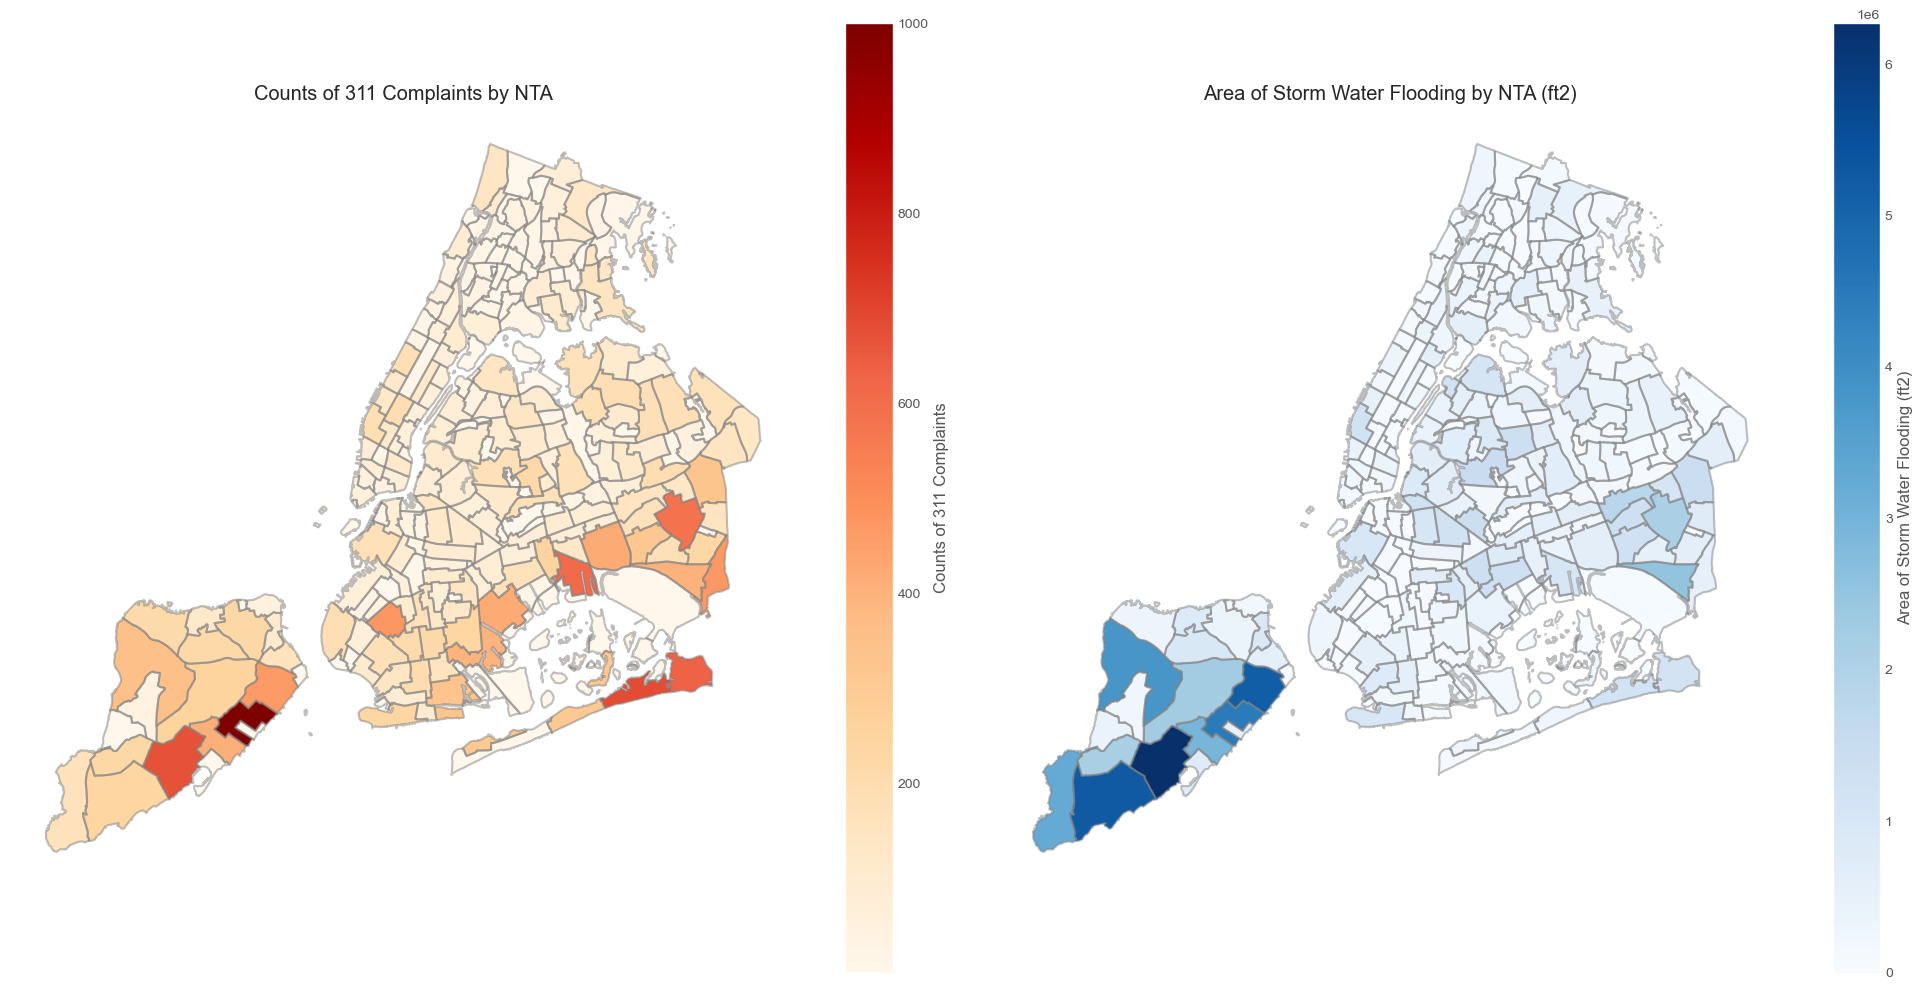

In [157]:
# create a choropleth map of 311 complaints counts and storm water flood area by NTAs

plt.style.use('ggplot')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

missing_kwds={"color": "lightgrey","edgecolor": "lightgrey","label": "Missing values"}
gdf_sw_nta.plot(
    ax=axs[0], column='count_311', cmap='OrRd', edgecolor="none", linewidth=1, legend=True,
    legend_kwds = {'label': "Counts of 311 Complaints"}, missing_kwds=missing_kwds)
gdf_nta.boundary.plot(ax=axs[0], color="grey", markersize=0.0001, alpha=0.5)

axs[0].set_title("Counts of 311 Complaints by NTA")
axs[0].set_axis_off()


missing_kwds={"color": "lightgrey","edgecolor": "lightgrey","label": "Missing values"}
gdf_sw_nta.plot(
    ax=axs[1], column='area_all', cmap='Blues', edgecolor="none", linewidth=1, legend=True,
    legend_kwds = {'label': "Area of Storm Water Flooding (ft2)"}, missing_kwds=missing_kwds)
gdf_nta.boundary.plot(ax=axs[1], color="grey", markersize=0.0001, alpha=0.5)

axs[1].set_title("Area of Storm Water Flooding by NTA (ft2)")
axs[1].set_axis_off()

plt.tight_layout()
plt.show()


## Statistical Analysis

 Assess relationship between area of floods and counts of 311 complaints

In [28]:
# fn_sw_nta = glob.glob("/Users/mac/Downloads/nyc-flood/data/processed/*.shp")[0]
fn_sw_nta = "/Users/ho/Documents/GitHub/nyc-flood/data/processed/nta_flood_vs_311.shp"

gdf_sw_nta = gpd.read_file(fn_sw_nta)

print(gdf_sw_nta.shape)
print(gdf_sw_nta.columns)


(262, 17)
Index(['BoroCode', 'BoroName', 'CountyFIPS', 'NTA2020', 'NTAName', 'NTAAbbrev',
       'NTAType', 'CDTA2020', 'CDTAName', 'Shape_Leng', 'Shape_Area',
       'CDTAName_2', 'area_1', 'area_2', 'area_all', 'count_311', 'geometry'],
      dtype='object')


### 1. Correlation

In [29]:
# correlation
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
print("Spearmans correlation")

spm_corrs = []

corr, _ = spearmanr(gdf_sw_nta['area_all'], gdf_sw_nta['count_311'])
spm_corrs += [corr]
print(f"-- All Flooding vs Counts of 311 Complaints: {np.round(corr, 2)}")

corr, _ = spearmanr(gdf_sw_nta['area_1'], gdf_sw_nta['count_311'])
print(f"-- Nuisance Flooding (1 ft > depth >= 4 inch) vs Counts of 311 Complaints: {np.round(corr, 2)}")
spm_corrs += [corr]

corr, _ = spearmanr(gdf_sw_nta['area_2'], gdf_sw_nta['count_311'])
print(f"-- Deep and Contiguous Flooding (depth >= 1 ft) vs Counts of 311 Complaints: {np.round(corr, 2)}")
spm_corrs += [corr]


Spearmans correlation
-- All Flooding vs Counts of 311 Complaints: 0.71
-- Nuisance Flooding (1 ft > depth >= 4 inch) vs Counts of 311 Complaints: 0.74
-- Deep and Contiguous Flooding (depth >= 1 ft) vs Counts of 311 Complaints: 0.63


/var/folders/ft/drjxcwpd0cb31nn1whf1scxh0000gn/T/ipykernel_20799/1769750736.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


<Figure size 640x480 with 0 Axes>

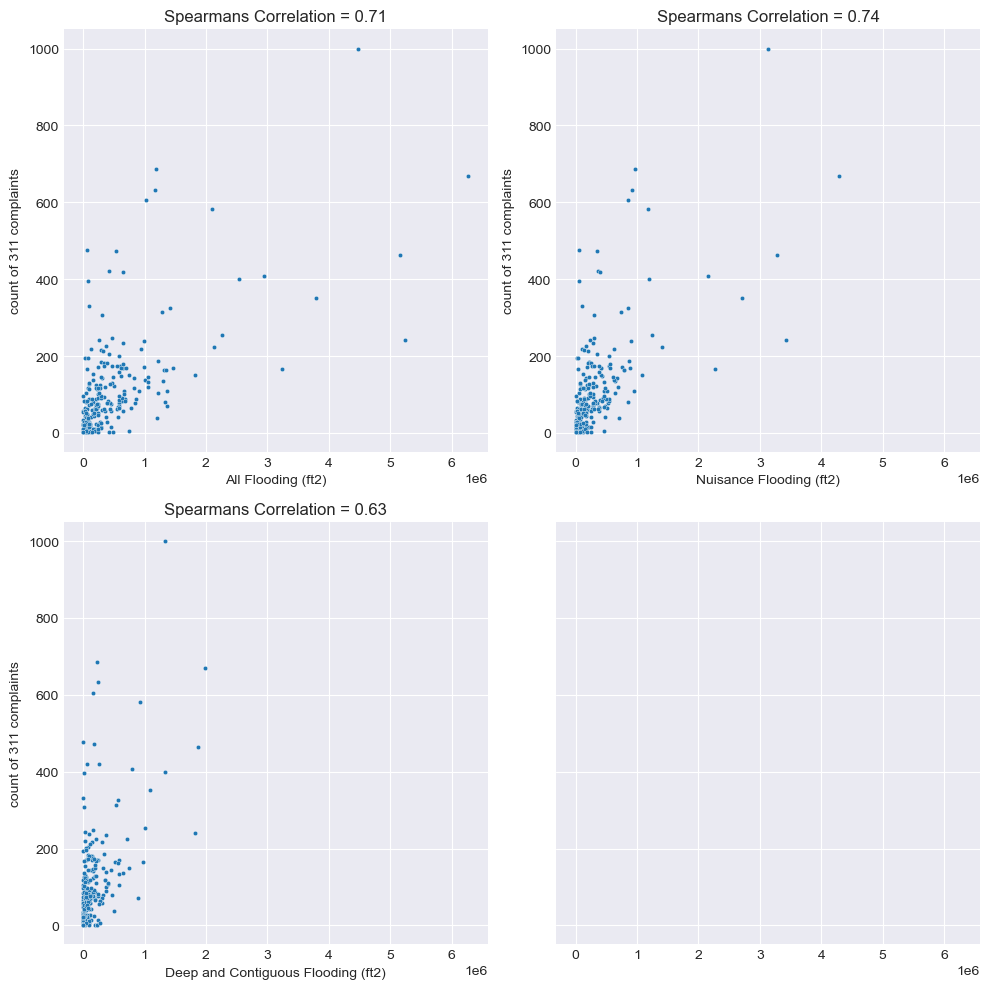

In [64]:
fds = ['area_all', 'area_1', 'area_2']
floodtypes = ['All Flooding (ft2)', 'Nuisance Flooding (ft2)', 'Deep and Contiguous Flooding (ft2)']

# plot
plt.clf()
plt.style.use("seaborn-darkgrid")
nrows = 2
ncols = 2
f, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                      figsize=(10, 10), sharex=True, sharey=True)
n = 0
for irow in range(0,nrows):
    for icol in range(0,ncols):

        try:   
            fd, spm_corr, floodtype = list(zip(fds, spm_corrs, floodtypes))[n]
        except:
            continue
        n += 1

        # scatterplot / lineplot
        scatter = sns.scatterplot(
            data=gdf_sw_nta, y="count_311", x=f"{fd}", 
            ax=axs[irow, icol], s=10) #, legend=False)

        # axs[irow, icol].plot(np.array(gdf_sw_nta["count_311"]), 
        #                     np.array(gdf_sw_nta[f"{fd}"]), color='r')

        scatter.set(title=f"Spearmans Correlation = {round(spm_corr, 2)}")
        scatter.set_xlabel(f"{floodtype}")
        scatter.set_ylabel("Count of 311 Complaints")

        axs[irow, icol].xaxis.get_label().set_visible(True)
        axs[irow, icol].yaxis.get_label().set_visible(True)

        axs[irow, icol].xaxis.set_tick_params(labelbottom=True)
        axs[irow, icol].yaxis.set_tick_params(labelleft=True)


plt.tight_layout()
plt.show()


### 2. Did people complain equally to minor flooding and severe flooding?

As the area of storm water flooding increase, the increase of the counts of 311 complaints slow down. (people who will complain alreay complain)

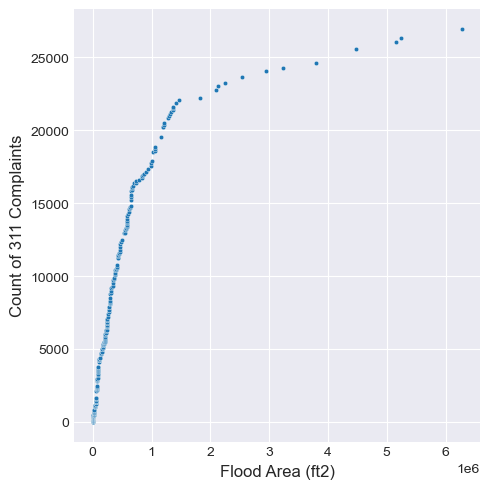

In [177]:
f, axs = plt.subplots(nrows=1, ncols=1, 
                      figsize=(5, 5), sharex=True, sharey=False)

gdf_sw_nta = gdf_sw_nta.sort_values(by='area_all')
gdf_sw_nta['count_311_cumsum'] = gdf_sw_nta.count_311.cumsum()

scatter = sns.scatterplot(
    data=gdf_sw_nta, x='area_all', 
    y='count_311_cumsum', 
    ax=axs, s=10, c="tab:blue")

scatter.set_xlabel(f"Flood Area (ft2)")
scatter.set_ylabel("Count of 311 Complaints")
plt.tight_layout()

People complained more when it's deep and contiguous flooding.

Text(0, 0.5, 'Cumulative Counts of 311 Complaints')

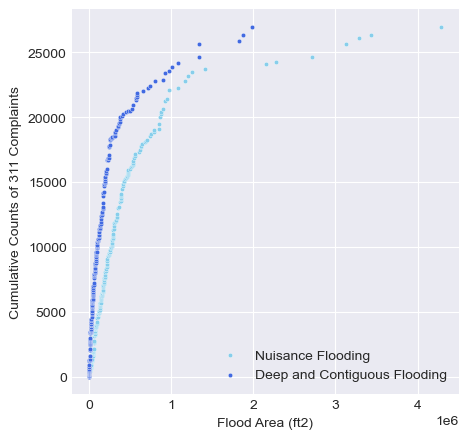

In [95]:
f, axs = plt.subplots(nrows=1, ncols=1, 
                      figsize=(5, 5), sharex=True, sharey=False)

gdf_sw_nta = gdf_sw_nta.sort_values(by='area_1')
gdf_sw_nta['count_311_cumsum'] = gdf_sw_nta.count_311.cumsum()

scatter = sns.scatterplot(
    data=gdf_sw_nta, x='area_1', 
    y='count_311_cumsum', 
    ax=axs, s=10, color="skyblue", legend=True)

gdf_sw_nta = gdf_sw_nta.sort_values(by='area_2')
gdf_sw_nta['count_311_cumsum'] = gdf_sw_nta.count_311.cumsum()

scatter = sns.scatterplot(
    data=gdf_sw_nta, x='area_2', 
    y='count_311_cumsum', 
    ax=axs, s=10, color='royalblue', legend=True)


plt.legend(['Nuisance Flooding', 'Deep and Contiguous Flooding'], loc="lower right")
axs.set_xlabel("Flood Area (ft2)")
axs.set_ylabel("Cumulative Counts of 311 Complaints")

### 3. Regression

The 311 counts are discrete count numbers and are usually modeled by Poisson distribution or negative binomial distribution. Here we use negative binomial distribution.


The result shows that when log(storm water flood area) increase by 1 unit, the counts of 311 complains increase by 10% in each neighborhood.

In [113]:
import statsmodels.api as sm

gdf_sw_nta['log_area_1'] = np.log(gdf_sw_nta['area_1']+.1)
gdf_sw_nta['log_area_2'] = np.log(gdf_sw_nta['area_2']+.1)
gdf_sw_nta['log_Shape_Area'] = np.log(gdf_sw_nta['Shape_Area']+.1)

y = gdf_sw_nta[['count_311']]
X = gdf_sw_nta[['log_area_all', 'log_Shape_Area']]
X = sm.add_constant(X)

glm_model = sm.GLM(y, X, family=sm.genmod.families.family.NegativeBinomial())
glm_result = glm_model.fit()


print(glm_result.aic)
print(glm_result.bic)

glm_result.summary()

# exp(0.0992)-1 = 0.104
## log(area_all) increae by 1 unit, count_311 increase by 10%

2721.0004753624216
-1184.041098602999


/Users/ho/opt/anaconda3/envs/nyc-flood/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1799: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              count_311   No. Observations:                  262
Model:                            GLM   Df Residuals:                      259
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1357.5
Date:                Fri, 17 Mar 2023   Deviance:                       258.16
Time:                        22:55:27   Pearson chi2:                     315.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5998
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.6930      1.403     -8.332      0.000     -14.443      -8.943
log_area_all       0.0992      0.015      6.743      0.000       0.070       0.128
log_Shape_Area     0.8739      0.086     10.111      0.000       0.705       1.043
==================================================================================
"""

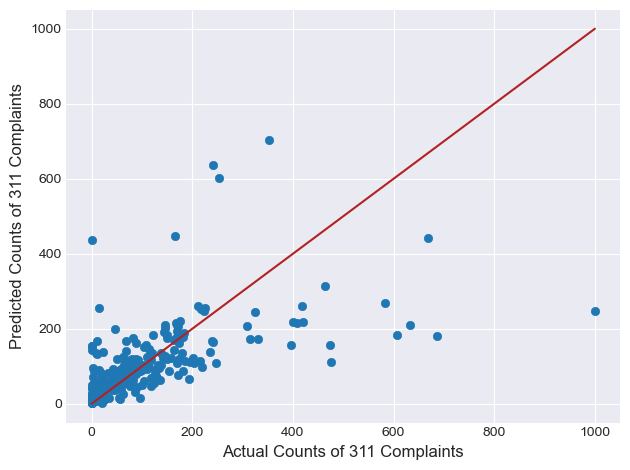

In [175]:
# if the model fit well, the points should fall along the red line.
# plt.style.use("seaborn-darkgrid")
plt.scatter(x=y, y=glm_result.fittedvalues, color='tab:blue')
plt.plot([0, 1000], [0, 1000], c='firebrick')
plt.xlabel('Actual Counts of 311 Complaints')
plt.ylabel('Predicted Counts of 311 Complaints')
plt.tight_layout()

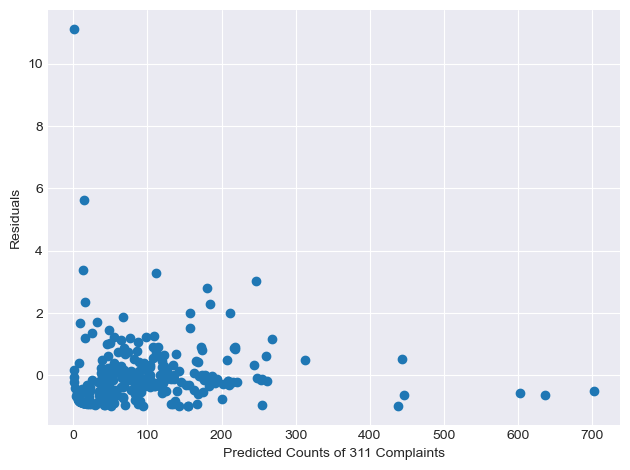

In [105]:
plt.scatter(glm_result.fittedvalues, glm_result.resid_pearson)
plt.xlabel('Predicted Counts of 311 Complaints')
plt.ylabel('Residuals')
plt.tight_layout()

## Next Step!

1. Are the coefficients vary spatially?
2. Are there other variables good predictors of the 311 flood complaints? eg. population, income level